<a href="https://colab.research.google.com/github/bhattacharya5/SpeechUnderstanding/blob/main/MinorProject/M21AIE211_MinorProject_Attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2"

/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2


# **Creating dataset**

In [ ]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
import glob

import os
from tqdm import tqdm  # Import tqdm for tracking progress

### **Copy clean speech**

In [ ]:
# Creating folder for all clean speech
!mkdir clean_speech

In [ ]:
source_dir = "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/LIBRISPEECH/LibriSpeech/train-clean-100/"
destination_dir = "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/clean_speech"

flac_files = glob.glob(source_dir + "/**/*.flac", recursive=True)[:5000]

flac_file_count = len(flac_files)

print("Number of .flac files before copying: ", flac_file_count)

for file in tqdm(flac_files):
    shutil.copy2(file, destination_dir)


Number of .flac files before copying:  5000


100%|██████████| 5000/5000 [02:41<00:00, 31.01it/s]


### **Create Noise files**

In [ ]:
!mkdir noise

In [ ]:
source_dir = "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/UrbanSound8K/"
destination_dir = "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/noise"

urbanSound_files = glob.glob(source_dir + "/**/*.wav", recursive=True)

urbanSound_files_count = len(urbanSound_files)

print("Number of urbanSound files before copying: ", urbanSound_files_count)

Number of urbanSound files before copying:  8732


In [ ]:
for file in tqdm(flac_files[:5000]):
    shutil.copy2(file, destination_dir)

100%|██████████| 5000/5000 [01:50<00:00, 45.25it/s]


In [ ]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=8000

In [ ]:
for i in tqdm(os.listdir('clean_speech')):
  count_clean += 1
  y,sr = librosa.load(os.path.join('clean_speech',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_clean+=duration

print(f'Number of clean audio files are {count_clean}')
print(f'Total duration of all clean audios {duration_clean//60}')

100%|██████████| 5000/5000 [02:19<00:00, 35.84it/s]

Number of clean audio files are 5054
Total duration of all clean audios 1077.0


In [ ]:
count_noise = 0
for i in tqdm(os.listdir('noise')):
  count_noise += 1
  y,sr = librosa.load(os.path.join('noise',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_noise+=duration

print(f'Number of Noisy audio files are {count_noise}')
print(f'Total duration of all noise audios {duration_noise//60}')

100%|██████████| 5000/5000 [01:39<00:00, 50.21it/s]

Number of Noisy audio files are 5000
Total duration of all noise audios 1076.0


# **Audio data pre-processing**

In [ ]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]
    # Creating several audio frames using sliding windows
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    # Combining all the frames to single matrix
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

# Required variables for Audio
noise_dir="noise/"
voice_dir="clean_speech/"
path_save_spectrogram="/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1


# clean Audio files
clean_audio_files = os.listdir(voice_dir)

# Selecting a random audio from clean speech
clean_random_audio = np.random.choice(clean_audio_files)

# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)

# Converting to Audio to numpy matrix
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

# Noisy Audio files
noisy_audio_files = os.listdir(voice_dir)

# Selecting a random audio from noise data
noisy_random_audio = np.random.choice(clean_audio_files)

# Load Audio
y,sr = librosa.load(os.path.join(voice_dir,noisy_random_audio),sr=sample_rate)

# Converting the Audio to numpy matrix
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))


clean = np.vstack(clean)
noise = np.vstack(noise)

Clean Audio: 3259-158083-0001.flac
Shape:(15, 8064)
Noise Audio: 19-227-0048.flac
Shape:(12, 8064)


In [ ]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [ ]:
prod_voice, prod_noise,prod_noisy_voice = blend_noise_randomly(voice=clean,noise=noise,nb_samples=10,frame_length=frame_length)

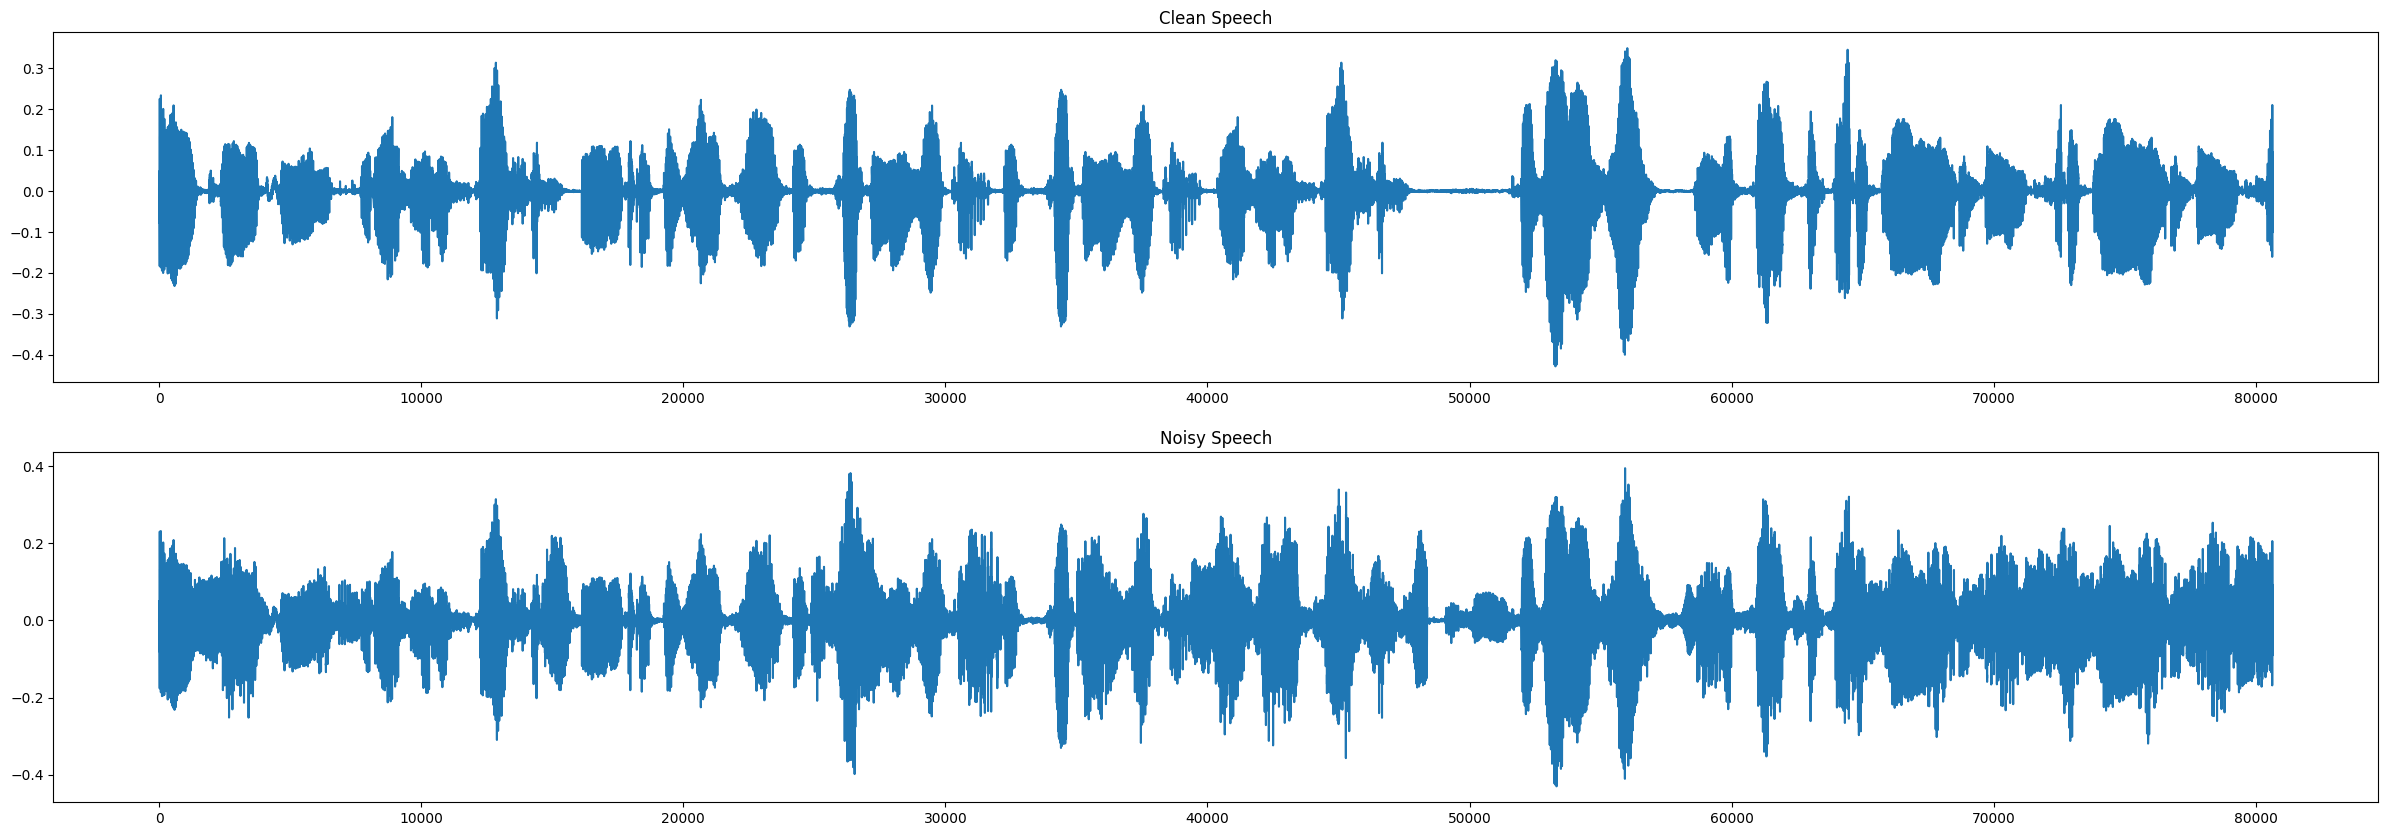

In [ ]:
#combine all the samples into a single sample for visualization
samples_clean = []
samples_noisy_clean = []
for x in prod_voice:
  samples_clean.extend(x)

for x in prod_noisy_voice:
  samples_noisy_clean.extend(x)

# After combining all samples to 1 (10*8064)
len(samples_clean)


import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()


# Saving and playing clean voice
import soundfile as sf
clean_nb_samples = prod_voice.shape[0]
#Save all frames in one file
clean_long = prod_voice.reshape(1, 10 * frame_length)*10
# librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write("clean_long.wav", clean_long[0,:], 8000, 'PCM_24')


from IPython.display import Audio
Audio('clean_long.wav')

In [ ]:
# Saving and playing noisy voice
noise_nb_samples = prod_noisy_voice.shape[0]
#Save all frames in one file
noise_long = prod_noisy_voice.reshape(1, 10 * frame_length)*10
sf.write("noise_long.wav", noise_long[0,:], 8000, 'PCM_24')


from IPython.display import Audio
Audio('noise_long.wav')

In [ ]:
#Create a function to convert the audio to magnitude and phase spectograms
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""


    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


#convert all the audio to magnitude and phase spectograms and save it as matrix
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    # we extract the magnitude vectors from the 256-point STFT vectors and
    # take the first 129-point by removing the symmetric half.

    nb_audio = numpy_audio.shape[0]
    # dim_square_spec = 256/2
    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

#create a function to combine all the pre-processing to prepare the audio data
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    count = 0
    for file in list_audio_files:
    # open the audio file
      try:
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        # Getting duration of audio file
        total_duration = librosa.get_duration(y=y, sr=sr)
      except ZeroDivisionError:
        count += 1

        # Check if the duration is atleast the minimum duration
      if (total_duration >= min_duration):
          list_sound_array.append(audio_to_audio_frame_stack(
              y, frame_length, hop_length_frame))
      else:
          print(
              f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)

In [ ]:
#Data Prepare
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
    and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
    time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
    parameters defined in args module"""

    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)


    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)             #Not required
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

# **Save spectogram**

In [ ]:
# Creating folder save the audio spectograms
!mkdir spectogram


noise_dir="noise/"
voice_dir="clean_speech/"
path_save_spectrogram="/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2/spectogram/"
sample_rate=8000
min_duration=1.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63

create_data(noise_dir=noise_dir,voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,min_duration=min_duration,frame_length=frame_length,hop_length_frame=hop_length_frame,hop_length_frame_noise=hop_length_frame_noise,nb_samples=nb_samples,n_fft=n_fft,hop_length_fft=hop_length_fft)


noisy_voice_amp_db = np.load('spectogram/noisy_voice_amp_db.npy')
print(np.shape(noisy_voice_amp_db))

mkdir: cannot create directory ‘spectogram’: File exists
(500, 128, 128)


# **Train Model & Evaluation**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(128, 2, 3, padding=1)
        self.conv10 = nn.Conv2d(2, 1, 1)
        self.up6 = nn.Conv2d(64, 64, 2, padding=0)
        self.up7 = nn.Conv2d(128, 128, 2, padding=0)
        self.up8 = nn.Conv2d(32, 32, 2, padding=0)
        self.up9 = nn.Conv2d(16, 16, 2, padding=0)

    def forward(self, x):
        conv1 = F.leaky_relu(self.conv1(x))
        conv1 = F.leaky_relu(self.conv2(conv1))
        pool1 = F.max_pool2d(conv1, 2)
        conv2 = F.leaky_relu(self.conv3(pool1))
        conv2 = F.leaky_relu(self.conv4(conv2))
        pool2 = F.max_pool2d(conv2, 2)
        conv3 = F.leaky_relu(self.conv5(pool2))
        conv3 = F.leaky_relu(self.conv6(conv3))
        pool3 = F.max_pool2d(conv3, 2)
        conv4 = F.leaky_relu(self.conv7(pool3))
        conv4 = F.leaky_relu(self.conv8(conv4))
        drop4 = F.dropout(conv4, p=0.5)
        pool4 = F.max_pool2d(drop4, 2)
        conv5 = F.leaky_relu(self.conv5(pool4))
        conv5 = F.leaky_relu(self.conv6(conv5))
        drop5 = F.dropout(conv5, p=0.5)
        up6 = F.leaky_relu(self.up6(F.interpolate(drop5, scale_factor=2, mode='bilinear', align_corners=True)))
        merge6 = torch.cat((drop4, up6), dim=1)
        conv6 = F.leaky_relu(self.conv7(merge6))
        conv6 = F.leaky_relu(self.conv8(conv6))
        up7 = F.leaky_relu(self.up7(F.interpolate(conv6, scale_factor=2, mode='bilinear', align_corners=True)))
        merge7 = torch.cat((conv3, up7), dim=1)
        conv7 = F.leaky_relu(self.conv7(merge7))
        conv7 = F.leaky_relu(self.conv8(conv7))
        up8 = F.leaky_relu(self.up8(F.interpolate(conv7, scale_factor=2, mode='bilinear', align_corners=True)))
        merge8 = torch.cat((conv2, up8), dim=1)
        conv8 = F.leaky_relu(self.conv3(merge8))
        conv8 = F.leaky_relu(self.conv4(conv8))
        up9 = F.leaky_relu(self.up9(F.interpolate(conv8, scale_factor=2, mode='bilinear', align_corners=True)))
        merge9 = torch.cat((conv1, up9), dim=1)
        conv9 = F.leaky_relu(self.conv1(merge9))
        conv9 = F.leaky_relu(self.conv2(conv9))
        conv9 = F.leaky_relu(self.conv9(conv9))
        conv10 = torch.tanh(self.conv10(conv9))
        return conv10

# Instantiate the model
model = UNet(in_channels=1, out_channels=1)

# Print the model architecture
print(model)


UNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  (up6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (up7): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (up8): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (up9): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Functions to scale audio files
def scaled_in(matrix_spec):
    # Global scaling apply to noisy voice spectrograms (scale between -1 and 1)
    matrix_spec = (matrix_spec + 46) / 50
    return matrix_spec

def scaled_out(matrix_spec):
    # Global scaling apply to noise models spectrograms (scale between -1 and 1)
    matrix_spec = (matrix_spec - 6) / 82
    return matrix_spec

# Load data
noisy_voice = np.load("spectogram/noisy_voice_amp_db.npy")
voice = np.load("spectogram/voice_amp_db.npy")
noise = noisy_voice - voice

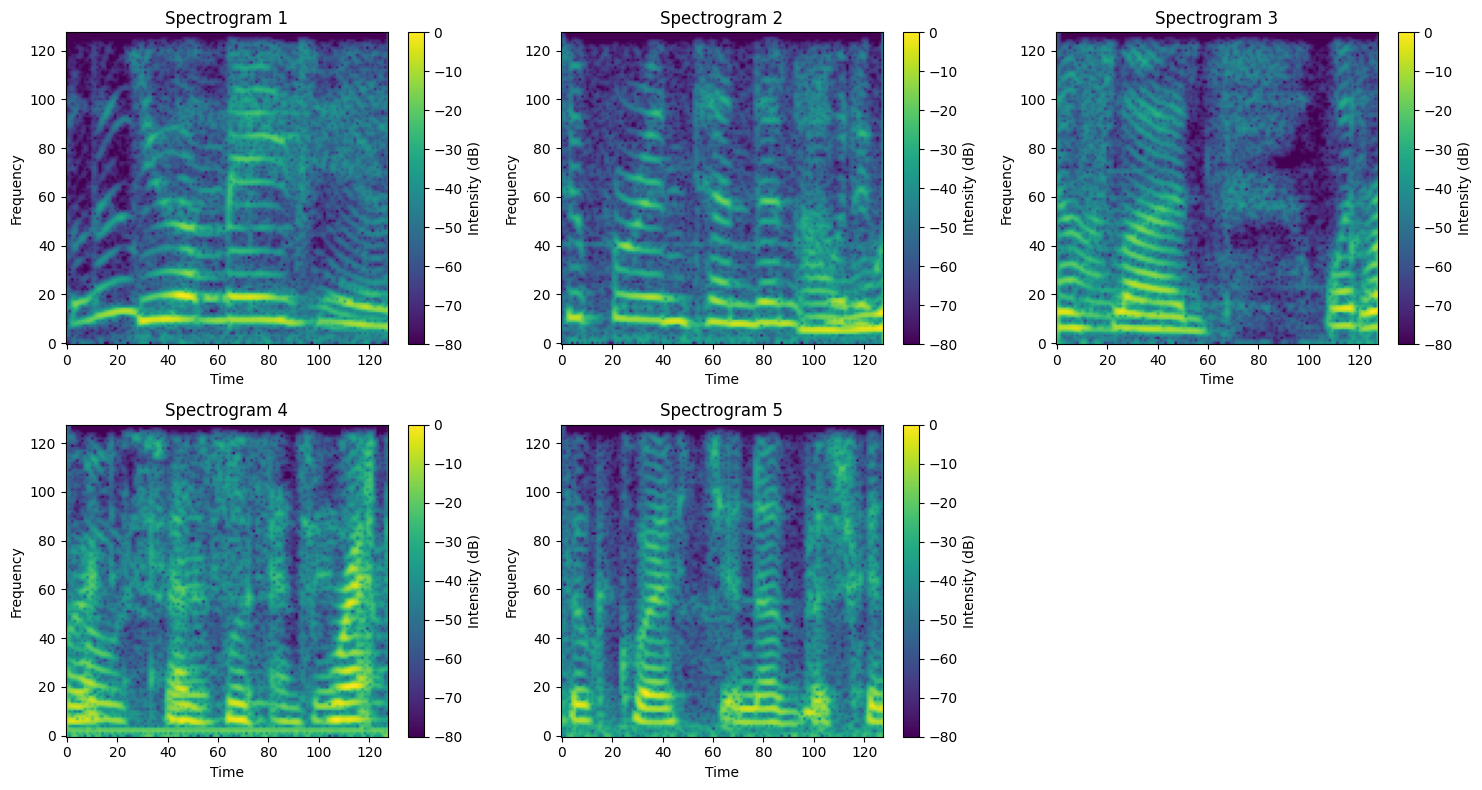

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the first 5 spectrograms
plt.figure(figsize=(15, 8))
for i, spectrogram in enumerate(noisy_voice):
  if (i < 5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Intensity (dB)')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Spectrogram {i + 1}')
plt.tight_layout()
plt.show()

In [ ]:
'''
# Reshape data
noisy_voice = np.expand_dims(noisy_voice, axis=-1)
noise = np.expand_dims(noise, axis=-1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(noisy_voice, noise, test_size=0.10, random_state=42)
'''

In [ ]:
#X_train.shape

(450, 128, 128, 1)

In [ ]:
#y_train.shape

(450, 128, 128, 1)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpectrogramDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_spec = torch.tensor(self.input_data[idx], dtype=torch.float32)
        target_spec = torch.tensor(self.target_data[idx], dtype=torch.float32)
        return input_spec, target_spec

# Assuming noisy_voice and noise have the same length
dataset = SpectrogramDataset(noisy_voice, noise)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Print the shape of data batches in train_loader
for inputs, targets in train_loader:
    print("Train Loader - Input shape:", inputs.shape)
    print("Train Loader - Target shape:", targets.shape)
    break  # Print the shape of the first batch only

# Print the shape of data batches in test_loader
for inputs, targets in test_loader:
    print("Test Loader - Input shape:", inputs.shape)
    print("Test Loader - Target shape:", targets.shape)
    break  # Print the shape of the first batch only


Train Loader - Input shape: torch.Size([64, 128, 128, 1])
Train Loader - Target shape: torch.Size([64, 128, 128, 1])
Test Loader - Input shape: torch.Size([64, 128, 128, 1])
Test Loader - Target shape: torch.Size([64, 128, 128, 1])


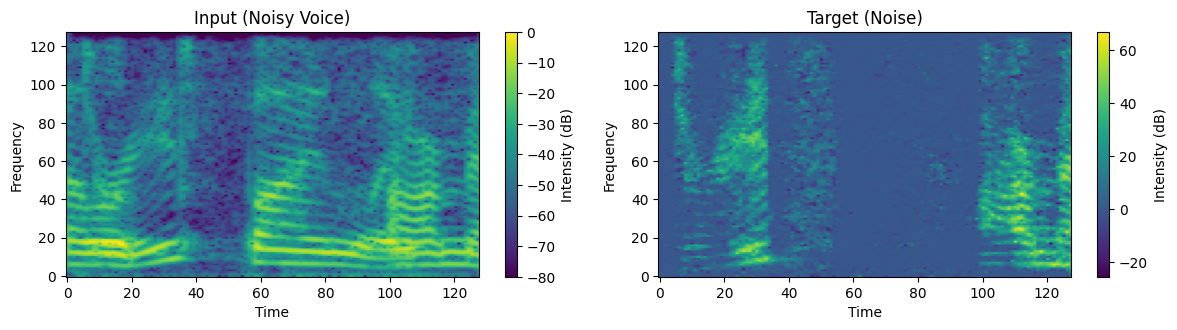

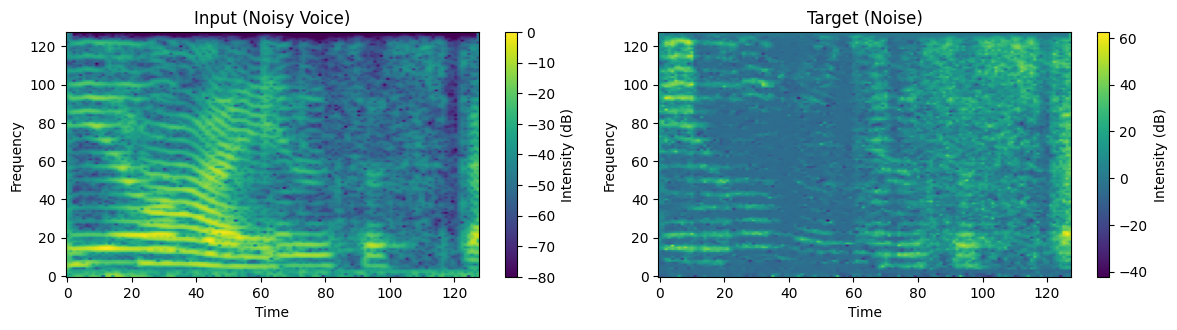

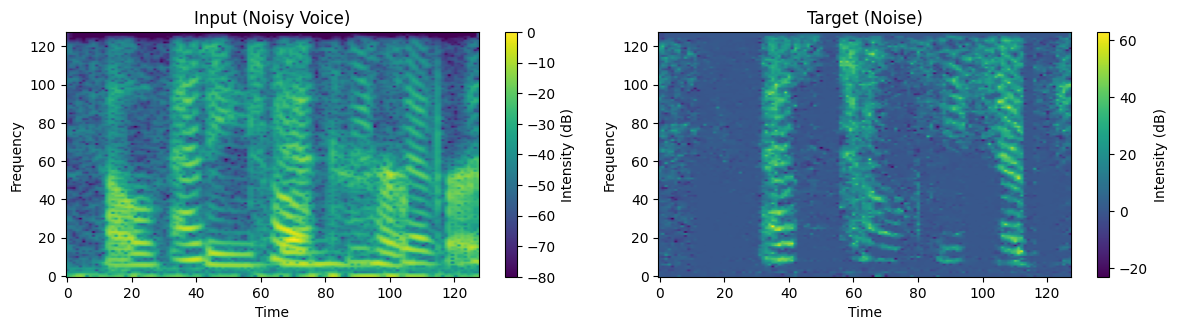

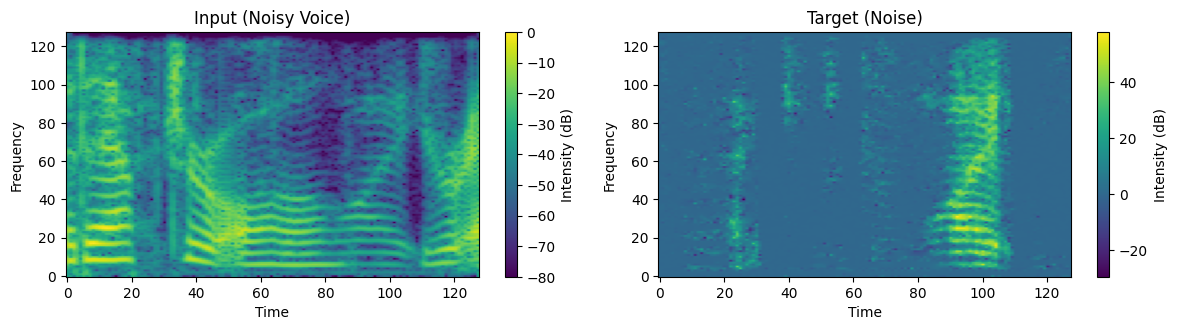

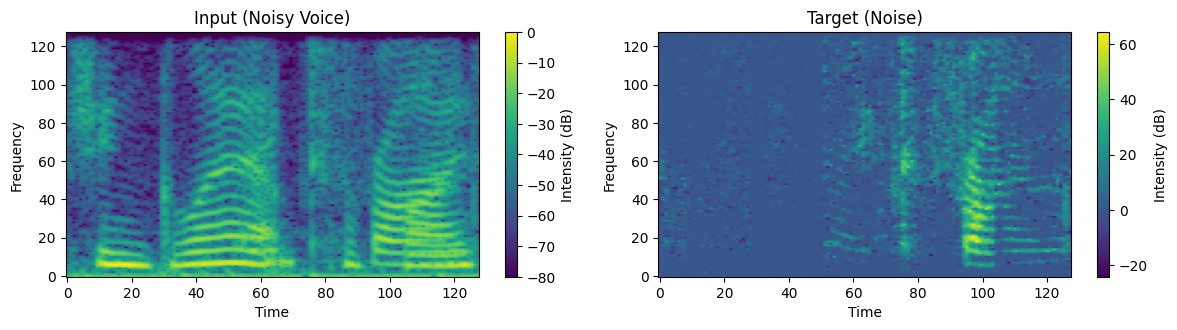

In [ ]:
import matplotlib.pyplot as plt

# Iterate over the first 5 examples from the train loader
for idx, (input_spec, target_spec) in enumerate(train_loader):
    if idx >= 5:
        break

    # Plot the input (noisy voice) and target (noise) spectrograms
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(input_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Intensity (dB)')
    plt.title('Input (Noisy Voice)')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.subplot(2, 2, 2)
    plt.imshow(target_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Intensity (dB)')
    plt.title('Target (Noise)')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
'''
from torch.utils.data import DataLoader, TensorDataset

batch_size = 10

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
'''

In [ ]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the UNet model in PyTorch
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Define the layers for the UNet model
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Define the forward pass through the UNet model
        x1 = F.relu(self.conv1(x))
        x_out = self.conv2(x1)
        return x_out

# Train the model
learning_rate = 0.01
epochs = 20
losses = []
val_losses = []

# Ensure the input data is in the correct shape [batch_size, in_channels, height, width]
X_train = X_train.permute(0, 3, 1, 2)  # Assuming X_train is the input data
X_test = X_test.permute(0, 3, 1, 2)  # Assuming X_test is the input data

# Instantiate the UNet model
model = UNet(in_channels=1, out_channels=1)






# Define the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            val_losses.append(val_loss.item())

# Save the trained model
torch.save(model.state_dict(), './weights/model_unet.pth')

# Plot training and validation loss
plt.plot(range(1, len(losses)+1), losses, label='Training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
'''

In [ ]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [ ]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Define encoder layers
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # Define decoder layers
        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.upconv5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1)
        self.upconv6 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv7 = nn.Conv2d(32, 16, 3, padding=1)

        # Output layer
        self.out_conv = nn.Conv2d(16, out_channels, 1)

    def forward(self, x):
        # Encoder
        x1 = F.leaky_relu(self.conv1(x))
        x2 = F.leaky_relu(self.conv2(F.max_pool2d(x1, 2)))
        x3 = F.leaky_relu(self.conv3(F.max_pool2d(x2, 2)))
        x4 = F.leaky_relu(self.conv4(F.max_pool2d(x3, 2)))

        # Decoder
        x = F.leaky_relu(self.upconv4(x4))
        x = torch.cat([x3, x], dim=1)
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.upconv5(x))
        x = torch.cat([x2, x], dim=1)
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.upconv6(x))
        x = torch.cat([x1, x], dim=1)
        x = F.leaky_relu(self.conv7(x))

        # Output layer
        x = self.out_conv(x)
        return x

# Instantiate the model
model = UNet(in_channels=1, out_channels=1)

# Print the model architecture
print(model)
'''

UNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv4): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv5): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv6): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Define the UNet model
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Define encoder layers
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # Define decoder layers
        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.upconv5 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv6 = nn.Conv2d(64, 32, 3, padding=1)
        self.upconv6 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv7 = nn.Conv2d(32, 16, 3, padding=1)

        # Output layer
        self.out_conv = nn.Conv2d(16, out_channels, 1)

    def forward(self, x):
        # Encoder
        x1 = F.leaky_relu(self.conv1(x))
        x2 = F.leaky_relu(self.conv2(F.max_pool2d(x1, 2)))
        x3 = F.leaky_relu(self.conv3(F.max_pool2d(x2, 2)))
        x4 = F.leaky_relu(self.conv4(F.max_pool2d(x3, 2)))

        # Decoder
        x = F.leaky_relu(self.upconv4(x4))
        x = torch.cat([x3, x], dim=1)
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.upconv5(x))
        x = torch.cat([x2, x], dim=1)
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.upconv6(x))
        x = torch.cat([x1, x], dim=1)
        x = F.leaky_relu(self.conv7(x))

        # Output layer
        x = self.out_conv(x)
        return x

# Instantiate the model
model = UNet(in_channels=1, out_channels=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        # Transpose the dimensions to match the input shape of the UNet model
        inputs = inputs.permute(0, 3, 1, 2)
        targets = targets.permute(0, 3, 1, 2)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        epoch_loss += loss.item() * inputs.size(0)

    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        # Transpose the dimensions to match the input shape of the UNet model
        inputs = inputs.permute(0, 3, 1, 2)
        targets = targets.permute(0, 3, 1, 2)

        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the trained model stored in `model` variable
# and a random input from the test noisy audios stored in `random_input` variable

# Set the model to evaluation mode
model.eval()

# Transpose the dimensions to match the input shape of the UNet model
random_input = random_input.permute(2, 0, 1).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(random_input)

# Plot the input, target, and output spectrograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(random_input.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.title('Input Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.imshow(target.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.title('Target Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.imshow(output.squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.title('Output Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Convert the output spectrogram back to the audio signal
output_audio = torchaudio.transforms.InverseMelScale()(output)

# Save the audio file generated by the model
torchaudio.save("output_audio.wav", output_audio.squeeze(), sample_rate=16000)
